In [1]:
#사용할 모듈 import
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import time
import os

In [8]:
#gpu 사용을 위해
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/home/compu/Documents/exports/item_merge/'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=64, shuffle=True, num_workers=8)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=32, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 15455
테스트 데이터셋 크기: 3862
클래스: ['fashion_sneakers', 'others']


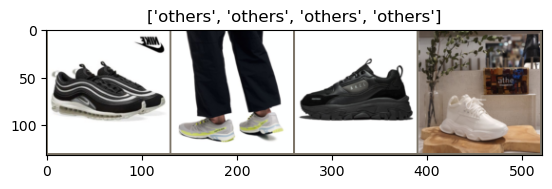

In [5]:
#학습데이터가 잘 들어 갔는지 확인하기 위해 실행

def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=8))

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [6]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [9]:
#모델 초기화 

model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 설정하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [10]:
num_epochs = 100
model.train()
start_time = time.time()

# early_stopping 객체 선언(5번의 epoch 연속으로 loss 미개선 시에 조기 종료 예시)
early_stopping = EarlyStopping(patience = 5, verbose = True)

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        #gradient를 0으로 초기화
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels).item()

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.
    
    ### early stopping 여부를 체크하는 부분 ###
    early_stopping(epoch_loss, model) # 현재 과적합 상황 추적
    
    if early_stopping.early_stop: # 조건 만족 시 조기 종료
        break

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

Validation loss decreased (inf --> 0.366027).  Saving model ...
#0 Loss: 0.3660 Acc: 83.7917% Time: 17.7603s
Validation loss decreased (0.366027 --> 0.225980).  Saving model ...
#1 Loss: 0.2260 Acc: 91.4526% Time: 35.3126s
Validation loss decreased (0.225980 --> 0.176567).  Saving model ...
#2 Loss: 0.1766 Acc: 93.4908% Time: 52.8627s
Validation loss decreased (0.176567 --> 0.133185).  Saving model ...
#3 Loss: 0.1332 Acc: 94.8431% Time: 70.6241s
Validation loss decreased (0.133185 --> 0.099577).  Saving model ...
#4 Loss: 0.0996 Acc: 96.3960% Time: 88.1840s
Validation loss decreased (0.099577 --> 0.072638).  Saving model ...
#5 Loss: 0.0726 Acc: 97.4571% Time: 106.0338s
Validation loss decreased (0.072638 --> 0.054774).  Saving model ...
#6 Loss: 0.0548 Acc: 98.2595% Time: 124.0102s
Validation loss decreased (0.054774 --> 0.049147).  Saving model ...
#7 Loss: 0.0491 Acc: 98.2142% Time: 141.9785s
Validation loss decreased (0.049147 --> 0.037273).  Saving model ...
#8 Loss: 0.0373 Acc: 

In [11]:
model.eval()
start_time = time.time()
running_loss = 0.
running_corrects = 0

preds_list = []
y_list = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels).item()

        # # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        # print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        # imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])
        preds_list.append(preds.float().cpu())
        y_list.append(labels.cpu())

    preds_list = np.concatenate(preds_list)
    y_list = np.concatenate(y_list)
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

[Test Phase] Loss: 0.0031 Acc: 99.8706% Time: 4.3277s


In [12]:
import sklearn.metrics as skm

print(skm.classification_report(y_list, preds_list))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1642
           1       0.92      0.94      0.93      2220

    accuracy                           0.92      3862
   macro avg       0.92      0.92      0.92      3862
weighted avg       0.92      0.92      0.92      3862



In [ ]:
model.eval()
start_time = time.time()

with torch.no_grad():
    preds_list = []
    y_list = []
    
    for i, (images, targets) in enumerate(test_dataloader):
        images = images.to(device)
        targets = targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)

        outputs = (outputs > 0.5).float()
        acc = (outputs == targets).float().mean()
        
        preds_list.append(outputs.float().cpu())
        y_list.append(targets.cpu())
        print(f'{i+1}: {loss.item():.5f}, {acc.item():.5f}, {time.time() - start_time}')
    
    preds_list = np.concatenate(preds_list)
    y_list = np.concatenate(y_list)

In [ ]:
# 저장된 pt 파일 로드

model = models.resnet34(num_classes=3) # 기본 가중치를 불러오지 않으므로 pretrained=True를 지정하지 않습니다.
model.load_state_dict(torch.load('checkpoint.pt'))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
#         imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))